# 015. Isolation Forest 를 이용한 NYC Taxi 탑승 정보 anomaly 검출

- 이상을 감지하는 최신 기술 중 하나는 Isolation Forest 입니다. 이 알고리즘은 anomaly data가 few and different 데이터 포인트라는 사실을 기반으로 합니다. 이러한 속성의 결과로 anomaly data는 isolation 이라는 메커니즘에 영향을 받기 쉽습니다.  

- 이 방법은 매우 유용하며 기존의 모든 방법과 근본적으로 다릅니다. 일반적으로 사용되는 기본 거리 및 밀도 측정 보다 이상을 감지하는 더 효과적이고 효율적인 수단으로 isolation을 사용합니다. 또한 이 방법은 선형 시간 복잡도가 낮고 메모리 요구 사항이 적은 알고리즘입니다. 데이터 세트의 크기에 관계없이 고정 크기의 작은 하위 샘플을 사용하여 적은 수의 트리로 우수한 성능의 모델을 구축합니다.

- Isolation Forest는 feature를 무작위로 선택한 다음 선택한 feature의 최대값과 최소값 사이의 분할 값을 무작위로 선택하여 관측치를 isolate 합니다.

- 재귀 분할은 트리 구조로 나타낼 수 있으므로 샘플을 분리하는 데 필요한 분할 수는 루트 노드에서 종료 노드까지의 경로 길이와 동일합니다.

- 이러한 random tree forest에서 평균을 낸 경로 길이는 정상성 판단과 결정 기능의 척도입니다.

- 랜덤 파티셔닝은 anomaly에 대해 더 짧은 경로를 생성합니다. 따라서 random tree forest가 집합적으로 특정 샘플에 대해 더 짧은 경로 길이를 생성하면 anomaly일 가능성이 높습니다.

- 일반적인 기계 학습 방법은 학습하려는 패턴이 균형을 이룰 때 더 잘 작동하는 경향이 있습니다.


### Isolation Forest 의 작동 방식

- Isolation Forest 알고리즘은 feature를 무작위로 선택한 다음 선택한 feature의 최대값과 최소값 사이의 분할 값을 무작위로 선택하여 관측치를 분리합니다. 

- Isolation forest는 기본적으로 데이터셋을 의사결정나무(Decision Tree) 형태로 표현해 정상값을 분리하기 위해서는 의사결정나무를 깊숙하게 타고 내려가야 하고, 반대로 이상값은 의사결정나무 상단부에서 분리할 수 있다는 것을 이용합니다. 이 특성을 사용해 의사결정나무를 몇 회 타고 내려가야 분리되는가를 기준으로 정상과 이상을 분리합니다.

- 알고리즘이 분리를 구성하는 방법은 먼저 isolation tree 또는 random decision tree 를 만드는 것입니다. 그런 다음 sample을 분리하기 위한 path의 길이로 score 를 계산합니다.

- Isolation forest의 장점

    - 군집기반 이상탐지 알고리즘에 비해 계산량이 매우 적다   
    - 강건한(Robust)한 모델을 만들 수 있다

In [1]:
import numpy as np
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import seaborn as sns

### Data download

- 2014년 7월 부터 2015년 1월까지의 New York 시의 taxi 탑승 횟수 정보를 30분 단위로 기록한 data 
- 요일별 / 시간별로 탑승횟수를 비교하여 이상치(교통량이 평소 보다 특별히 많거나 적은 날) 검출

In [2]:
url = "https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv"
df = pd.read_csv(url)
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  10320 non-null  object
 1   value      10320 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 161.4+ KB


- timestamp column 을 object --> datetime64 로 변경

In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  10320 non-null  datetime64[ns]
 1   value      10320 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 161.4 KB


## Feature Engineering
- 시간 간격이 30분 단위이면 다루기 어려우므로, 1 시간 단위로 resample

In [5]:
df = df.set_index('timestamp').resample('H').mean().reset_index()
df.head()

,timestamp,value
0,2014-07-01 00:00:00,9485.5
1,2014-07-01 01:00:00,5433.0
2,2014-07-01 02:00:00,3346.5
3,2014-07-01 03:00:00,2216.5
4,2014-07-01 04:00:00,2189.5


-  `timestamp`로 부터 `시간`, `요일`을 new feature로 생성하여  column 추가  

In [6]:
df['hour'] = df.timestamp.dt.hour
df['weekday'] = df.timestamp.dt.strftime('%A')

df.head()

,timestamp,value,hour,weekday
0,2014-07-01 00:00:00,9485.5,0,Tuesday
1,2014-07-01 01:00:00,5433.0,1,Tuesday
2,2014-07-01 02:00:00,3346.5,2,Tuesday
3,2014-07-01 03:00:00,2216.5,3,Tuesday
4,2014-07-01 04:00:00,2189.5,4,Tuesday


## EDA를 통해 시각적으로 Abnormal 한 날짜 검출

- 요일별 평균 탑승 횟수 시각화

<Axes: xlabel='weekday'>

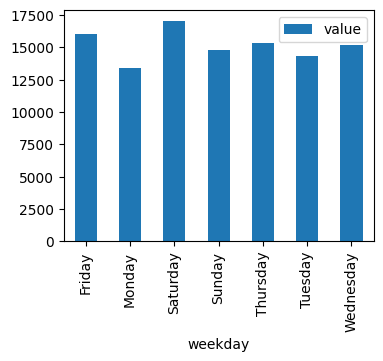

In [7]:
# 'value' 칼럼을 'weekday' 칼럼에 따라 그룹화하고, 각 그룹의 평균을 계산합니다.
# 그 결과를 막대 그래프로 시각화합니다.
df[['value', 'weekday']].groupby('weekday').mean().plot(kind='bar', figsize=(4, 3))

- 시간대별 평균 탑승 횟수 시각화

<Axes: xlabel='hour'>

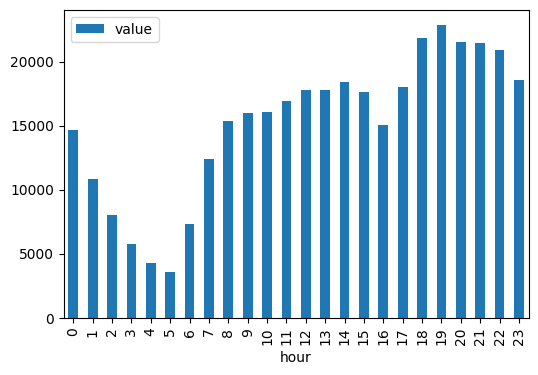

In [8]:
# 'value' 칼럼을 'hour' 칼럼에 따라 그룹화하고, 각 그룹의 평균을 계산합니다.
# 이를 통해 시간대별(value에 대한) 평균 값을 얻을 수 있습니다.
df[['value', 'hour']].groupby('hour').mean().plot(kind='bar', figsize=(6, 4))

- 전체 시계열 시각화

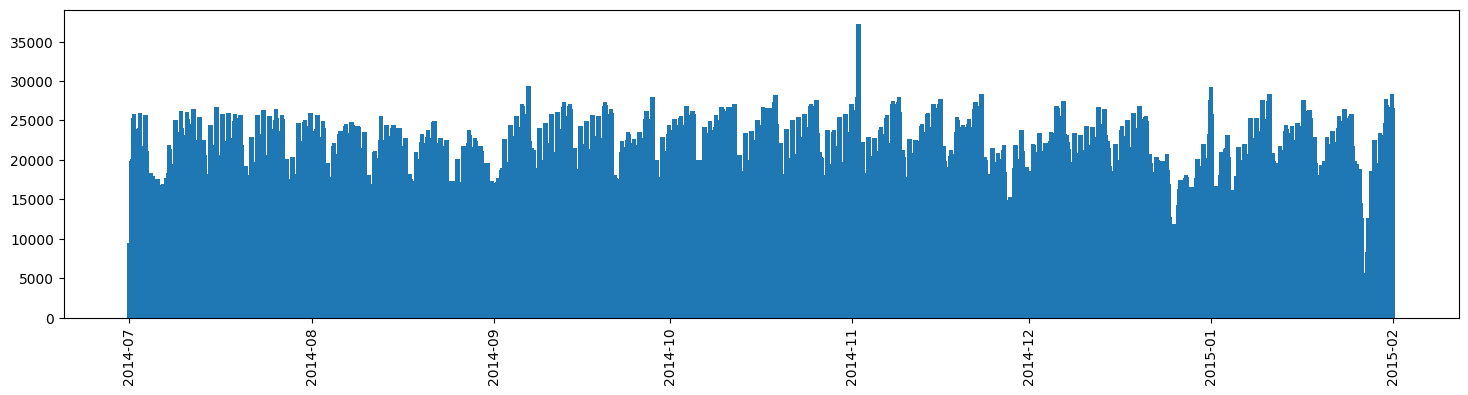

In [9]:
plt.figure(figsize=(18, 4))
plt.bar(df.timestamp, df.value)
plt.xticks(rotation=90)
plt.show()

2014.11 부근에 큰 peak 가 보이고, 2015.2 이전에 매우 작은 값이 보인다.  
2014-11-02 는 뉴욕마라톤이 있어 관광객이 많았으며,  2015-01-27 에는 눈보라가 있어 교통이 마비 되었음.  

해당일자 기간을 확대하여 시각화

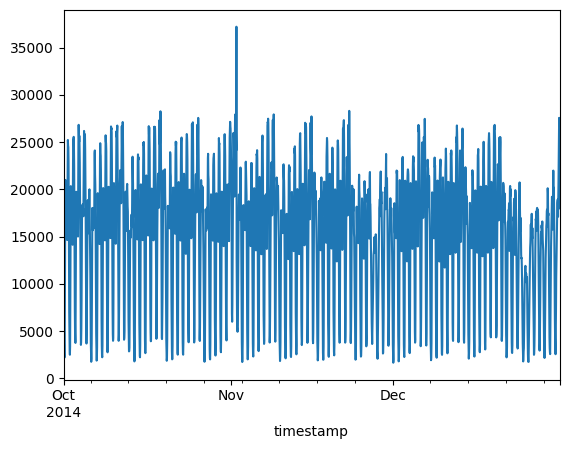

In [10]:
# 'timestamp' 열을 인덱스로 설정한 후, 
# 2014년 10월부터 2014년 12월까지의 데이터를 선택하고 'value' 열을 추출합니다.
series = df.set_index('timestamp').loc['2014-10':'2014-12']['value']

series.plot()
plt.show()

<Axes: xlabel='timestamp'>

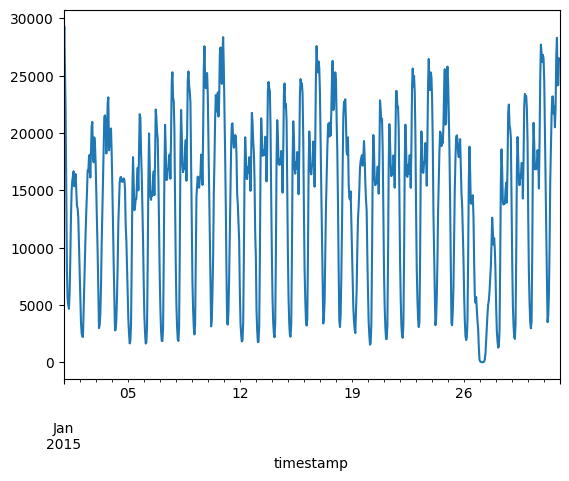

In [11]:
series = df.set_index('timestamp').loc['2015-01':'2015-02']['value']
series.plot()

## Isolation Forest를 이용하여 이상치 검출

### 1 - contamination parameter 를 이용한 threshold control  
contamination parameter - dataset 내의 이상치 비율

In [12]:
# n_estimators: 트리의 개수를 500개로 설정
# contamination: 데이터셋에서 이상치로 간주되는 비율을 0.004 (0.4%)로 설정
# random_state: 결과의 재현성을 위해 난수 생성기의 시드를 0으로 설정
model = IsolationForest(n_estimators=500, 
                        contamination=0.004, random_state=0)

#value와 hour 특성을 가진 데이터에 대해 학습
model.fit(df[['value','hour']].values)

IsolationForest(contamination=0.004, n_estimators=500, random_state=0)

outliers 검출. anomaly 는 -1. normal 은 1.

In [13]:
np.unique(model.predict(df[['value', 'hour']].values))

array([-1,  1])

outlier는 `yes`로 표시.

In [14]:
# IsolationForest 모델을 사용하여 df[['value', 'hour']]의 각 데이터 포인트에 대한 이상치 여부를 예측
# model.predict()는 이상치인 경우 -1, 정상인 경우 1을 반환
# 반환된 예측 결과를 pandas Series로 변환
predictions = pd.Series(model.predict(df[['value', 'hour']].values))

# 예측 결과에 따라 'yes' 또는 'no'를 반환하는 함수를 apply 메소드를 통해 적용
# 이상치인 경우 (-1) 'yes', 정상인 경우 (1) 'no'를 할당
df['outliers'] = predictions.apply(lambda x: 'yes' if (x == -1) else 'no')

In [15]:
df.query('outliers == "yes"')

,timestamp,value,hour,weekday,outliers
1631,2014-09-06 23:00:00,29418.5,23,Saturday,yes
1800,2014-09-14 00:00:00,26473.5,0,Sunday,yes
1968,2014-09-21 00:00:00,25969.0,0,Sunday,yes
2136,2014-09-28 00:00:00,26794.5,0,Sunday,yes
2472,2014-10-12 00:00:00,26005.0,0,Sunday,yes
2640,2014-10-19 00:00:00,27146.5,0,Sunday,yes
2808,2014-10-26 00:00:00,26560.0,0,Sunday,yes
2977,2014-11-02 01:00:00,37204.5,1,Sunday,yes
3144,2014-11-09 00:00:00,26069.5,0,Sunday,yes
3312,2014-11-16 00:00:00,25931.5,0,Sunday,yes


<Axes: xlabel='timestamp', ylabel='value'>

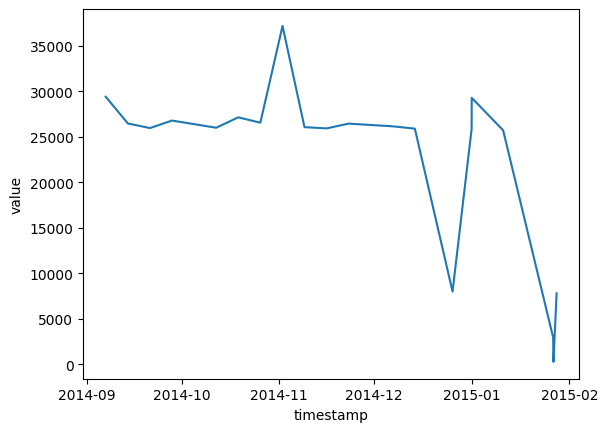

In [16]:
sns.lineplot(x='timestamp', y='value', 
             data=df.query('outliers == "yes"'))

### 2 - 임의의 threshold 설정 

scores - 입력 샘플의 anomaly score 입니다. 낮을수록 비정상적입니다. 음수 점수는 outlier를 나타내고 양수 점수는 inlier를 나타냅니다.

In [17]:
# n_estimators=500: 500개의 트리를 사용하여 모델을 구성합니다.
model = IsolationForest(n_estimators=500, random_state=0)

# df 데이터프레임의 'value' 열과 'hour' 열을 사용하여 모델을 학습시킵니다.
model.fit(df[['value', 'hour']].values)

IsolationForest(n_estimators=500, random_state=0)

- decision_function - 평균 anomaly score 계산

In [18]:
# IsolationForest 모델을 사용하여 'value'와 'hour' 열로 구성된 데이터를 평가합니다.
# decision_function 메서드는 각 데이터 포인트의 이상치 점수를 반환합니다.
# 이상치 점수는 음수 값을 가지며, 값이 작을수록 더 이상치임을 나타냅니다.
score = model.decision_function(df[['value', 'hour']].values)

# 이상치 점수를 출력합니다.
print(score)

[-0.06047915 -0.02974712 -0.00808499 ... -0.00387494 -0.08516736
 -0.11697285]


Text(0, 0.5, 'frequencey')

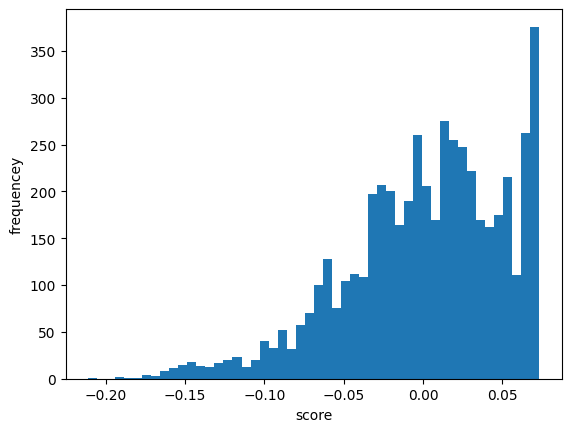

In [19]:
plt.hist(score, bins=50);
plt.xlabel("score")
plt.ylabel("frequencey")

In [20]:
df['score'] = score
df.head()

,timestamp,value,hour,weekday,outliers,score
0,2014-07-01 00:00:00,9485.5,0,Tuesday,no,-0.060479
1,2014-07-01 01:00:00,5433.0,1,Tuesday,no,-0.029747
2,2014-07-01 02:00:00,3346.5,2,Tuesday,no,-0.008085
3,2014-07-01 03:00:00,2216.5,3,Tuesday,no,-0.019942
4,2014-07-01 04:00:00,2189.5,4,Tuesday,no,-0.009827


contamination parameter 와 임의의 score로 설정한 threshold 결과를 조합하여 비교하며 domain knowlege를 이용하여 outlier(교통량이 평소보다 특별히 많거나 적은 날) 를 구분하면 된다.  

- 2014-07-04~07 : 독립기념일  
- 2014-09-06 : 노동절 행진  
- 2014-11-02 : 뉴욕 마라톤 대회  
- 2015-01-26~28 : 심한 눈보라

In [21]:
# score 열의 값이 -0.16보다 작고, outliers 열의 값이 "yes"인 행을 선택합니다.
filtered_df = df.query('score < -0.16 and outliers == "yes"')
filtered_df

,timestamp,value,hour,weekday,outliers,score
1631,2014-09-06 23:00:00,29418.5,23,Saturday,yes,-0.161217
1800,2014-09-14 00:00:00,26473.5,0,Sunday,yes,-0.173419
1968,2014-09-21 00:00:00,25969.0,0,Sunday,yes,-0.164428
2136,2014-09-28 00:00:00,26794.5,0,Sunday,yes,-0.175949
2472,2014-10-12 00:00:00,26005.0,0,Sunday,yes,-0.165147
2640,2014-10-19 00:00:00,27146.5,0,Sunday,yes,-0.179793
2808,2014-10-26 00:00:00,26560.0,0,Sunday,yes,-0.174422
2977,2014-11-02 01:00:00,37204.5,1,Sunday,yes,-0.190897
3144,2014-11-09 00:00:00,26069.5,0,Sunday,yes,-0.166409
3312,2014-11-16 00:00:00,25931.5,0,Sunday,yes,-0.163722


결론 - EDA 를 통해 manually 찾아낸 abnormal 한 일자와 Isolated Forest 를 이용하여 Machine Learning으로 찾아낸 일자가 거의 일치함